In [522]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from requests import delete
from sklearn.model_selection import train_test_split
from sympy import false
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torch.optim.lr_scheduler import StepLR

In [523]:
#expected to be a directory with submission, companyfacts, ticker.txt and company_tickers.json all available on SEC website
data_dir = "data"

facts_dir = os.path.join(data_dir, "facts")
stock_data_dir = os.path.join(data_dir, "stock_data")

company_data_dir = os.path.join(data_dir, "company_data")

submissions_dir = os.path.join(data_dir, "submission")
company_facts_dir = os.path.join(data_dir, "companyfacts")

data_csv = os.path.join(data_dir, "all_data.csv")

In [524]:
print(data_csv)
df = pd.read_csv(data_csv)
# df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])
# df = df[df['log_return'] <= 1]
df = df.sort_values(by=['CIK', 'date'])
df.drop(["date", "open", "high", "low", "close","weekly_trend"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)


print(df.shape)

# pd.set_option('display.max_columns', None)
# print(df.head(10))
# pd.reset_option('display.max_columns')

# pd.set_option('display.max_rows', None)
# print(df.dtypes)
# pd.reset_option('display.max_rows')


data/all_data.csv
(1440877, 58)


In [525]:
class DataNormalizer:
    def normalize_per_company(self, columns):
        for column in columns:
            self.df[column] = self.df.groupby('CIK')[column].transform(lambda x: (x - x.mean()) / x.std())
        return self.df

    def normalize_globally(self, columns):
        scaler = StandardScaler()
        self.df[columns] = scaler.fit_transform(self.df[columns])
        return self.df
    def min_max_normalize(self, columns):
        for column in columns:
            self.df[column] = (self.df[column] - self.df[column].min()) / (self.df[column].max() - self.df[column].min())
        return df
    def keep_original(self, columns):
        return self.df

    def __init__(self, df):
        self.df = df
        self.per_company_stats = {}
        self.global_scalers = {}

    def normalize(self, per_company_columns=None, global_columns=None, min_max_columns=None, no_norm_columns=None):
        if per_company_columns:
            self.df = self.normalize_per_company(per_company_columns)
        if global_columns:
            self.df = self.normalize_globally(global_columns)
        if min_max_columns:
            self.df = self.min_max_normalize(min_max_columns)
        if no_norm_columns:
            self.df = self.keep_original(no_norm_columns)
        return self.df

In [526]:
per_company_columns = [
    'ichimoku_a', 'ichimoku_b', 'ichimoku_base_line', 'SMA_30', 'SMA_60', 'EMA_60', 
    'EMA_90', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_60', 'RSI_90', 
    'ROC_60', 'ROC_90', 'CCI_60', 'CCI_90', 'ATR_30', 'OBV', 'MFI_60', 'MFI_90', 
    'bb_upper', 'bb_lower', 'bb_width', 'rolling_mean_90','rolling_std_90',
    'Assets', 'AssetsCurrent', 'CashAndCashEquivalentsAtCarryingValue',
    'CommonStockParOrStatedValuePerShare', 'CommonStockSharesAuthorized',
    'CommonStockSharesIssued', 'CommonStockValue', 'ComprehensiveIncomeNetOfTax',
    'EarningsPerShareBasic', 'EarningsPerShareDiluted', 'GrossProfit',
    'IncomeTaxExpenseBenefit', 'InterestExpense', 'LiabilitiesAndStockholdersEquity',
    'LiabilitiesCurrent', 'NetCashProvidedByUsedInFinancingActivities',
    'NetCashProvidedByUsedInInvestingActivities',
    'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss',
    'PropertyPlantAndEquipmentNet', 'RetainedEarningsAccumulatedDeficit',
    'ShareBasedCompensation', 'StockholdersEquity',
    'WeightedAverageNumberOfDilutedSharesOutstanding', 'Liabilities',
    'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
    'WeightedAverageNumberOfSharesOutstandingBasic',
    'OperatingIncomeLoss', 'volume'
]

global_columns = [

     
]

min_max_columns = [
    'CIK', 'week', 'weekday'
]

no_norm_columns = [

]

data_normalizer = DataNormalizer(df)

df = data_normalizer.normalize(
    per_company_columns=per_company_columns,
    global_columns=global_columns,
    min_max_columns=min_max_columns,
    no_norm_columns=no_norm_columns
)

In [527]:
print("Shape of DataFrame:", df.shape)

pd.set_option('display.max_columns', None)
print(df.head(10))

numeric_cols = df.select_dtypes(include=[np.number]).columns

summary = {}

for col in numeric_cols:
    mean_val = df[col].mean()
    count_gt_1 = (df[col] > 1).sum()

    summary[col] = {
        'mean': mean_val,
        'count > 1': count_gt_1
    }

summary_df = pd.DataFrame(summary).T

print(summary_df)

df = df[~(df[numeric_cols] > 1).any(axis=1)]

print("\nShape after dropping > 1", df.shape) #Needed for now later, Fix in the making

pd.reset_option('display.max_columns')


Shape of DataFrame: (1440877, 58)
         Assets  CashAndCashEquivalentsAtCarryingValue  \
10079  0.591137                               2.480959   
10080  0.591137                               2.480959   
10081  0.591137                               2.480959   
10082  0.591137                               2.480959   
10083  0.591137                               2.480959   
10084  0.591137                               2.480959   
10085  0.591137                               2.480959   
10086  0.591137                               2.480959   
10087  0.591137                               2.480959   
10088  0.591137                               2.480959   

       CommonStockParOrStatedValuePerShare  CommonStockSharesAuthorized  \
10079                                  NaN                    -0.466692   
10080                                  NaN                    -0.466692   
10081                                  NaN                    -0.466692   
10082                      

In [528]:
class StockDataset(Dataset):
    def __init__(self, df, X_columns, y_column, sequence_length=180, prediction_length=90, stride=None, shuffle_cik=False):
        self.df = df.copy()
        self.X_columns = X_columns
        self.y_column = y_column
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.stride = stride if stride is not None else sequence_length

        self.df[X_columns] = self.df[X_columns].astype(np.float32)
        self.df[y_column] = self.df[y_column].astype(np.float32)

        grouped = self.df.groupby("CIK")
        cik_groups = [group for _, group in grouped]

        if shuffle_cik:
            random.shuffle(cik_groups)

        self.index_map = []
        self.group_map = []

        for group in cik_groups:
            group = group.reset_index(drop=True)
            values = group[X_columns].values
            targets = group[y_column].values

            max_start = len(group) - (sequence_length + prediction_length)
            if max_start < 1:
                continue

            for i in range(0, max_start, self.stride):
                self.index_map.append((len(self.group_map), i))
            self.group_map.append((values, targets))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        group_idx, offset = self.index_map[idx]
        values, targets = self.group_map[group_idx]

        X_seq = values[offset:offset+self.sequence_length]
        y_target = targets[offset+self.sequence_length : offset+self.sequence_length+self.prediction_length]

        X_mask = ~np.isnan(X_seq)
        X_seq = np.nan_to_num(X_seq, nan=0.0)

        return (
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_target, dtype=torch.float32),
            torch.tensor(X_mask, dtype=torch.bool)
        )


In [529]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_layer_size,
            num_layers,
            bias = False,
            batch_first = True,
            bidirectional = False,
            dropout = 0.3
           )

        self.linear = nn.Linear(hidden_layer_size, output_size, bias=False)
    def forward(self, x):
        _, (hidden, cell) = self.lstm(x)
        out = hidden[-1]
        out = self.linear(out)

        return out


In [530]:
y_column = 'log_return'
X_columns = [col for col in df.columns if col != y_column]

cik_unique = df['CIK'].unique()
train_cik, val_cik = train_test_split(cik_unique, test_size=0.2, random_state=42)

train_df = df[df['CIK'].isin(train_cik)]
val_df = df[df['CIK'].isin(val_cik)]

batch_size = 64
sequence_length = 180
prediction_length = 90

train_dataset = StockDataset(train_df, X_columns, y_column, sequence_length=sequence_length,
                             prediction_length=prediction_length, shuffle_cik=False)
val_dataset = StockDataset(val_df, X_columns, y_column, sequence_length=sequence_length,
                           prediction_length=prediction_length, shuffle_cik=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [531]:
sample_idx = random.randint(0, 200)

# Get test sample
X_sample, y_sample, X_mask = train_dataset[sample_idx]

# Print shapes
print(f"X shape: {X_sample.shape}")         # (sequence_length, num_features)
print(f"y shape: {y_sample.shape}")         # (prediction_length,)
print(f"Mask shape: {X_mask.shape}")        # (sequence_length, num_features)

print("\nX sample (first 2 time steps):")
print(X_sample[:2])

print("\ny target (first 10 steps):")
print(y_sample[:10])


X shape: torch.Size([180, 57])
y shape: torch.Size([90])
Mask shape: torch.Size([180, 57])

X sample (first 2 time steps):
tensor([[-1.1106, -1.1363,  0.0000,  0.0000, -1.3323,  0.0000,  0.3875,  0.0000,
          0.0000,  0.4004,  0.4048, -0.4884, -0.9383, -1.1106, -0.5189,  0.3663,
          0.2651,  0.3799, -1.3203,  0.3395, -1.2314, -1.2784, -1.2249, -0.7253,
         -0.7844, -0.8559, -0.8244, -0.8205, -0.8224, -0.8486, -0.8486, -0.2101,
         -0.0590, -0.2040, -0.4786, -0.4786, -0.4830, -0.4830, -0.2441, -0.2441,
         -0.9499, -1.2067, -1.0198, -1.0198, -0.8822, -0.7180, -0.8800, -0.8477,
         -0.9198,  0.0577,  0.5000,  0.5850, -1.1439,  0.1101, -0.6942,  0.7449,
         -0.5681],
        [-1.1106, -1.1363,  0.0000,  0.0000, -1.3323,  0.0000,  0.3875,  0.0000,
          0.0000,  0.4004,  0.4048, -0.4884, -0.9383, -1.1106, -0.5189,  0.3663,
          0.2651,  0.3799, -1.3203,  0.3395, -1.2314, -1.2784, -1.2249, -0.6839,
         -0.7830, -0.8559, -0.8264, -0.8241, -0.

In [624]:
from functools import partial
input_size = len(X_columns)
hidden_layer_size = 8
num_layers = 2
output_size = 90
epochs = 180

model = LSTMModel(
    input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, output_size=output_size)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

loss_function = partial(torch.nn.functional.huber_loss, delta=0.025)
# loss_function = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
train_losses = []
val_losses = []

In [625]:
from sklearn.metrics import mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().flatten()
    y_pred = y_pred.detach().cpu().numpy().flatten()

    r2 = r2_score(y_true, y_pred)
    directional_acc = (np.sign(y_true) == np.sign(y_pred)).mean()

    return r2, directional_acc

In [626]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    y_train_all = []
    y_train_pred_all = []

    for batch_x, batch_y, mask in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_x)

        loss = loss_function(predictions, batch_y)
        loss.backward()

        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         grad_norm = param.grad.norm().item()
        #         print(f"Grad norm | {name:30}: {grad_norm:.6f}")

        optimizer.step()

        epoch_loss += loss.item()

        y_train_all.append(batch_y)
        y_train_pred_all.append(predictions)

    avg_epoch_loss = epoch_loss / len(train_loader)
    y_train_all = torch.cat(y_train_all)
    y_train_pred_all = torch.cat(y_train_pred_all)

    train_r2, train_dir_acc = compute_metrics(y_train_all, y_train_pred_all)
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"R2: {train_r2:.4f}, ↑↓ Acc: {train_dir_acc:.4f}")

    train_losses.append(avg_epoch_loss)

    model.eval()
    val_loss = 0
    y_val_all = []
    y_val_pred_all = []

    with torch.no_grad():
        for val_x, val_y, mask in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            mask = mask.to(device)

            predictions = model(val_x)
            loss = loss_function(predictions, val_y)

            val_loss += loss.item()
            y_val_all.append(val_y)
            y_val_pred_all.append(predictions)

    avg_val_loss = val_loss / len(val_loader)

    y_val_all = torch.cat(y_val_all)
    y_val_pred_all = torch.cat(y_val_pred_all)
    val_r2, val_dir_acc = compute_metrics(y_val_all, y_val_pred_all)

    print(f"{' ' * len(f'Epoch {epoch + 1}/{epochs}')}"
          f"Val Loss: {avg_val_loss:.4f}, "
          f"R2: {val_r2:.4f}, ↑↓ Acc: {val_dir_acc:.4f}")

    scheduler.step(avg_val_loss)
    val_losses.append(avg_val_loss)

Epoch 1/180, Train Loss: 0.0006, R2: -0.4728, ↑↓ Acc: 0.4519
           Val Loss: 0.0005, R2: -0.4974, ↑↓ Acc: 0.4272
Epoch 2/180, Train Loss: 0.0006, R2: -0.4297, ↑↓ Acc: 0.4496
           Val Loss: 0.0004, R2: -0.4434, ↑↓ Acc: 0.4248
Epoch 3/180, Train Loss: 0.0005, R2: -0.3514, ↑↓ Acc: 0.4502
           Val Loss: 0.0004, R2: -0.3976, ↑↓ Acc: 0.4262
Epoch 4/180, Train Loss: 0.0005, R2: -0.3235, ↑↓ Acc: 0.4513
           Val Loss: 0.0004, R2: -0.3592, ↑↓ Acc: 0.4248
Epoch 5/180, Train Loss: 0.0005, R2: -0.2972, ↑↓ Acc: 0.4493
           Val Loss: 0.0004, R2: -0.3261, ↑↓ Acc: 0.4251
Epoch 6/180, Train Loss: 0.0005, R2: -0.2452, ↑↓ Acc: 0.4505
           Val Loss: 0.0004, R2: -0.2979, ↑↓ Acc: 0.4247
Epoch 7/180, Train Loss: 0.0005, R2: -0.2468, ↑↓ Acc: 0.4524
           Val Loss: 0.0004, R2: -0.2737, ↑↓ Acc: 0.4248
Epoch 8/180, Train Loss: 0.0005, R2: -0.2116, ↑↓ Acc: 0.4533
           Val Loss: 0.0004, R2: -0.2527, ↑↓ Acc: 0.4253
Epoch 9/180, Train Loss: 0.0004, R2: -0.2050, ↑↓ Acc: 0.

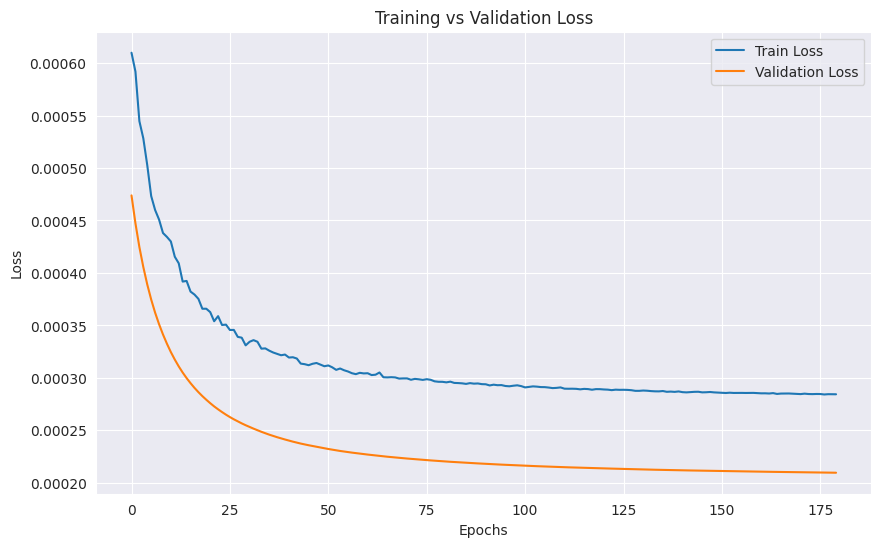

In [627]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


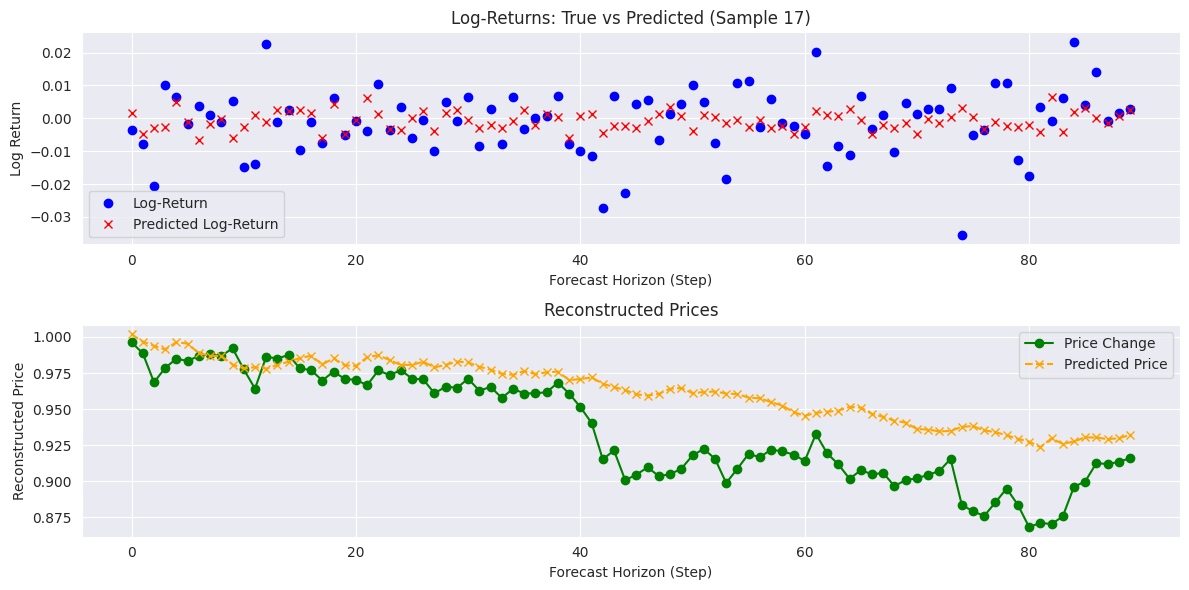

In [645]:
import random
import matplotlib.pyplot as plt

prediction_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
model.eval()

with torch.no_grad():
    data_iter = iter(prediction_loader)

    val_x, val_y, mask = next(data_iter)
    val_x = val_x.to(device)
    mask = mask.to(device)

    preds = model(val_x).cpu().numpy()
    targets = val_y.cpu().numpy()

    sample_idx = random.randint(0, val_x.size(0) - 1)

    sample_pred = preds[sample_idx]
    sample_target = targets[sample_idx]

    initial_price = 1.0

    cumsum_target = np.cumsum(sample_target)
    cumsum_pred = np.cumsum(sample_pred)

    price_target = initial_price * np.exp(cumsum_target)
    price_pred = initial_price * np.exp(cumsum_pred)


    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(sample_target, label='Log-Return', marker='o', linestyle='', color='blue')
    plt.plot(sample_pred, label='Predicted Log-Return', marker='x', linestyle='', color='red')
    plt.xlabel('Forecast Horizon (Step)')
    plt.ylabel('Log Return')
    plt.title(f'Log-Returns: True vs Predicted (Sample {sample_idx})')
    plt.legend()
    plt.grid(True)


    plt.subplot(2, 1, 2)
    plt.plot(price_target, label='Price Change', marker='o', linestyle='-', color='green')
    plt.plot(price_pred, label='Predicted Price', marker='x', linestyle='--', color='orange')
    plt.xlabel('Forecast Horizon (Step)')
    plt.ylabel('Reconstructed Price')
    plt.title('Reconstructed Prices')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
